In [ ]:
# Evaluation Based Sampling Implementation
import torch
from torch import distributions as dist
from daphne import daphne
from tests import is_tol, run_prob_test,load_truth
from primitives import funcprimitives

env = {'normal': dist.Normal,
       'sqrt': torch.sqrt,
       '+': torch.add,
       '-': torch.sub,
       '*': torch.mul,
       '/': torch.div,
       'beta': dist.Beta,
       'gamma': dist.Gamma,
       'dirichlet': dist.Dirichlet,
       'exponential': dist.Exponential,
       'discrete': dist.Categorical,
       'uniform': dist.Uniform,
       'uniform-continuous': dist.Uniform,
       'vector': funcprimitives["vector"],
       'get': funcprimitives["get"],
       'put': funcprimitives["put"],
       'hash-map': funcprimitives["hash-map"],
       'first': funcprimitives["first"],
       'second': funcprimitives["second"],
       'last': funcprimitives["last"],
       'append': funcprimitives["append"],
       'conj': funcprimitives["conj"],
       'cons': funcprimitives["cons"],
       'list': funcprimitives["list"],
       '<': funcprimitives["less_than"],
       'mat-mul': torch.matmul,
       'mat-repmat': lambda x, y, z: x.repeat((int(y.item()), int(z.item()))),
       'mat-add': torch.add,
       'mat-tanh': torch.tanh,
       'mat-transpose': torch.t,
       'rest': funcprimitives["rest"],
      }

def evaluate(exp, loc_env, procedure_defs):
#     print(exp, loc_env, "\n------------------------------------------")

    if type(exp) is int or type(exp) is float:
        return torch.tensor(float(exp))
    
    elif type(exp) is str:
        return loc_env[exp]

    elif type(exp) is list:
        prim = exp[0]
        
        if prim == "let":
            loc_env[exp[1][0]] = evaluate(exp[1][1], loc_env, procedure_defs)
            return evaluate(exp[2], loc_env, procedure_defs)
        
        elif prim == "sample":
            return evaluate(exp[1], loc_env, procedure_defs).sample()
        
        elif prim == "if":
            e_prime = evaluate(exp[1], loc_env, procedure_defs)
            if e_prime:
                return evaluate(exp[2], loc_env, procedure_defs)
            return evaluate(exp[3], loc_env, procedure_defs)

        # we do not implement for now
        elif prim == "observe":
            return torch.tensor(0.0)
        
        elif prim in env:
            # need this otherwise loc_env is lost
            eval_exp = [evaluate(x, loc_env, procedure_defs) for x in exp[1:]]
            return env[prim](*eval_exp)

        else:
            # evaluate the rest of the input expresions
            eval_exps = [evaluate(e, loc_env, procedure_defs) for e in exp[1:]]
           
            if prim in procedure_defs:    
                # iterate over function variables
                for i, var in enumerate(procedure_defs[exp[0]]["vars"]):
                    loc_env[var] = eval_exps[i]
                e0_prime = procedure_defs[prim]["fn_exp"]
                return evaluate(e0_prime, loc_env, procedure_defs)

            else:
                return eval_exps 

    else:
        raise("Expression type unknown.", exp)

    

def evaluate_program(ast):
    """Evaluate a program as desugared by daphne, generate a sample from the prior
    Args:
        ast: json FOPPL program
    Returns: sample from the prior of ast
    """
    copy_ast = ast[:]
    loc_env = {}
    procedure_defs = {}
    
    for exp in copy_ast:
        if exp[0] == "defn":
            defn = {"vars": exp[2], "fn_exp": exp[3]}
            procedure_defs[exp[1]] = defn

    return evaluate(copy_ast[-1], loc_env, procedure_defs), {}  # empty sigma

def get_stream(ast):
    """Return a stream of prior samples"""
    while True:
        yield evaluate_program(ast)[0]
    


def run_deterministic_tests():
    
    for i in range(1,14):
        #note: this path should be with respect to the daphne path!
        ast = daphne(['desugar', '-i', '../CS532-HW2/programs/tests/deterministic/test_{}.daphne'.format(i)])
        truth = load_truth('programs/tests/deterministic/test_{}.truth'.format(i))
        ret, sig = evaluate_program(ast)
        try:
            assert(is_tol(ret, truth))
        except AssertionError:
            raise AssertionError('return value {} is not equal to truth {} for exp {}'.format(ret,truth,ast))
        
        print('Test passed')
        
    print('All deterministic tests passed')
    


def run_probabilistic_tests():
    
    num_samples=1e4
    max_p_value = 1e-4
    
    for i in range(1,7):
        #note: this path should be with respect to the daphne path!        
        ast = daphne(['desugar', '-i', '../CS532-HW2/programs/tests/probabilistic/test_{}.daphne'.format(i)])
        truth = load_truth('programs/tests/probabilistic/test_{}.truth'.format(i))
        
        stream = get_stream(ast)
        
        p_val = run_prob_test(stream, truth, num_samples)
        
        print('p value', p_val)
        assert(p_val > max_p_value)
    
    print('All probabilistic tests passed')    

In [ ]:
# Graph Based Sampling Implementation
import torch
import torch.distributions as dist

from daphne import daphne

from primitives import funcprimitives #TODO
from tests import is_tol, run_prob_test,load_truth

# Put all function mappings from the deterministic language environment to your
# Python evaluation context here:
env = {'normal': dist.Normal,
       'sqrt': torch.sqrt,
       '+': torch.add,
       '-': torch.sub,
       '*': torch.mul,
       '/': torch.div,
       'beta': dist.Beta,
       'gamma': dist.Gamma,
       'dirichlet': dist.Dirichlet,
       'exponential': dist.Exponential,
       'discrete': dist.Categorical,
       'uniform': dist.Uniform,
       'uniform-continuous': dist.Uniform,
       'vector': funcprimitives["vector"],
       'get': funcprimitives["get"],
       'put': funcprimitives["put"],
       'hash-map': funcprimitives["hash-map"],
       'first': funcprimitives["first"],
       'second': funcprimitives["second"],
       'last': funcprimitives["last"],
       'append': funcprimitives["append"],
       'conj': funcprimitives["conj"],
       'cons': funcprimitives["cons"],
       'list': funcprimitives["list"],
       '<': funcprimitives["less_than"],
       'mat-mul': torch.matmul,
       'mat-repmat': lambda x, y, z: x.repeat((int(y.item()), int(z.item()))),
       'mat-add': torch.add,
       'mat-tanh': torch.tanh,
       'mat-transpose': torch.t,
       'rest': funcprimitives["rest"],
      }


def deterministic_eval(exp):
    "Evaluation function for the deterministic target language of the graph based representation."
    if type(exp) is list:
        op = exp[0]
        args = exp[1:]
        return env[op](*map(deterministic_eval, args))
    elif type(exp) is int or type(exp) is float:
        # We use torch for all numerical objects in our evaluator
        return torch.tensor(float(exp))
    else:
        raise("Expression type unknown.", exp)

def evaluate(exp, loc_env, procedure_defs):
#     print(exp, loc_env, "\n------------------------------------------")

    if type(exp) is int or type(exp) is float:
        return torch.tensor(float(exp))
    
    elif type(exp) is str:
        return loc_env[exp]

    elif type(exp) is list:
        prim = exp[0]
        
        if prim == "let":
            loc_env[exp[1][0]] = evaluate(exp[1][1], loc_env, procedure_defs)
            return evaluate(exp[2], loc_env, procedure_defs)
        
        elif prim == "sample*":
            return evaluate(exp[1], loc_env, procedure_defs).sample()
        
        elif prim == "if":
            e_prime = evaluate(exp[1], loc_env, procedure_defs)
            if e_prime:
                return evaluate(exp[2], loc_env, procedure_defs)
            return evaluate(exp[3], loc_env, procedure_defs)

        # we do not implement for now
        elif prim == "observe*":
            return torch.tensor(0.0)
        
        elif prim in env:
            # need this otherwise loc_env is lost
            eval_exp = [evaluate(x, loc_env, procedure_defs) for x in exp[1:]]
            return env[prim](*eval_exp)

        else:
            # evaluate the rest of the input expresions
            eval_exps = [evaluate(e, loc_env, procedure_defs) for e in exp[1:]]
           
            if prim in procedure_defs:    
                # iterate over function variables
                for i, var in enumerate(procedure_defs[prim][1]):
                    loc_env[var] = eval_exps[i]
                e0_prime = procedure_defs[prim][2]
                return evaluate(e0_prime, loc_env, procedure_defs)

            else:
                return eval_exps 

    else:
        raise("Expression type unknown.", exp)

             
def sample_from_joint(graph):
    "This function does ancestral sampling starting from the prior."
    
    fn_defs = graph[0]
    body = graph[1]
    E = graph[2]

    all_vars = body["V"]
    dependencies = body["A"]
    link_fns = body["P"]
    side_effects = body["Y"]
    
    # TODO(innaivanova): do not actually depend on the naming of the parent vars
    sorted_parents = sorted(dependencies.keys(), key=lambda x: int(x[6:]))
    local_env = {}

    for parent in sorted_parents:
        local_env[parent] = evaluate(link_fns[parent], local_env, fn_defs)
        
    for var, exp in link_fns.items():
        local_env[var] = evaluate(exp, local_env, fn_defs)

    return evaluate(E, local_env, fn_defs)



def get_stream(graph):
    """Return a stream of prior samples
    Args: 
        graph: json graph as loaded by daphne wrapper
    Returns: a python iterator with an infinite stream of samples
        """
    while True:
        yield sample_from_joint(graph)   



#Testing:

def run_deterministic_tests():
    
    for i in range(1,13):
        #note: this path should be with respect to the daphne path!
        graph = daphne(['graph','-i','../CS532-HW2/programs/tests/deterministic/test_{}.daphne'.format(i)])
        truth = load_truth('programs/tests/deterministic/test_{}.truth'.format(i))
        ret = deterministic_eval(graph[-1])
        try:
            assert(is_tol(ret, truth))
        except AssertionError:
            raise AssertionError('return value {} is not equal to truth {} for graph {}'.format(ret,truth,graph))
        
        print('Test passed')
        
    print('All deterministic tests passed')
    


def run_probabilistic_tests():
    
    #TODO: 
    num_samples=1e4
    max_p_value = 1e-4
    
    for i in range(1,7):
        #note: this path should be with respect to the daphne path!        
        graph = daphne(['graph', '-i', '../CS532-HW2/programs/tests/probabilistic/test_{}.daphne'.format(i)])
        truth = load_truth('programs/tests/probabilistic/test_{}.truth'.format(i))
        
        stream = get_stream(graph)
        
        p_val = run_prob_test(stream, truth, num_samples)
        
        print('p value', p_val)
        assert(p_val > max_p_value)
    
    print('All probabilistic tests passed')    

In [ ]:
# Primitive functions
import torch

def vector(*arg):
    # general case
    try:
        return torch.stack(arg, dim=0)
    
    # for concatenation of many vectors
    except RuntimeError:
        dim = len(arg[0].shape) - 1
        return torch.cat(arg, dim=dim)
    
    # for distribution objects
    except TypeError:
        return list(arg)

def get(v, i):
    return v[int(i.item())]

def put(v, i, c):
    v[int(i.item())] = c
    return v

def first(v):
    return v[0]

def second(v):
    return v[1]

def last(v):
    return v[-1]

def append(v, c):
    return torch.cat((v, c.unsqueeze(dim=0)), dim=0)

def hashmap(*v):
    hm = {}
    i = 0
    while i < len(v):
        hm[v[i].item()] = v[i+1]
        i+=2
    return hm

def less_than(*args):
    return args[0] < args[1]

def rest(v):
    return v[1:]

def l(*arg):
    return list(arg)

def cons(x, l):
    return [x] + l    

funcprimitives = {
    "vector": vector,
    "get": get,
    "put": put,
    "first": first,
    "last": last,
    "append": append,
    "hash-map": hashmap,
    "less_than": less_than,
    "second": second,
    "rest": rest,
    "conj": append,
    "list": l,
    "cons": cons,
}

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from daphne import daphne
import evaluation_based_sampling as ebs
import graph_based_sampling as gbs

In [2]:
print("Evaluation Based Sampling Tests\n")
ebs.run_deterministic_tests()
print()
ebs.run_probabilistic_tests()

print("\nSamples for the more sophisticated programs using ebs")
for i in range(1,5):
    ast = daphne(['desugar', '-i', '../CS532-HW2/programs/{}.daphne'.format(i)])
    print('\n\n\nSample of prior of program {}:'.format(i))
    print(ebs.evaluate_program(ast)[0])

Evaluation Based Sampling Tests

Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
All deterministic tests passed

('normal', 5, 1.4142136)
p value 0.9505526212524408
('beta', 2.0, 5.0)
p value 0.08423025289384833
('exponential', 0.0, 5.0)
p value 0.5022415531735367
('normal', 5.3, 3.2)
p value 0.7933855967000957
('normalmix', 0.1, -1, 0.3, 0.9, 1, 0.3)
p value 0.6890078638616574
('normal', 0, 1.44)
p value 0.3576133853064135
All probabilistic tests passed

Samples for the more sophisticated programs using ebs



Sample of prior of program 1:
tensor(6.9183)



Sample of prior of program 2:
tensor([  4.0990, -11.7461])



Sample of prior of program 3:
tensor([1, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2])



Sample of prior of program 4:
tensor([[ 1.1233e+00, -9.1335e-02, -8.1721e-01, -8.0753e-01, -7.3668e-01,
         -8.9452e-01, -1.6845e-01, -1.5108e-01, -9.5647e-02, -1.7842

In [3]:
print("Graph Based Sampling Tests\n")
gbs.run_deterministic_tests()
print()
gbs.run_probabilistic_tests()

print("\nSamples for the more sophisticated programs using gbs")

for i in range(1,5):
    graph = daphne(['graph','-i','../CS532-HW2/programs/{}.daphne'.format(i)])
    print('\n\n\nSample of prior of program {}:'.format(i))
    print(gbs.sample_from_joint(graph)) 

Graph Based Sampling Tests

Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
All deterministic tests passed

('normal', 5, 1.4142136)
p value 0.7171982505789456
('beta', 2.0, 5.0)
p value 0.8011360572849142
('exponential', 0.0, 5.0)
p value 0.15870443256045752
('normal', 5.3, 3.2)
p value 0.10878226477436115
('normalmix', 0.1, -1, 0.3, 0.9, 1, 0.3)
p value 0.5438441592716319
('normal', 0, 1.44)
p value 0.2332535821966688
All probabilistic tests passed

Samples for the more sophisticated programs using gbs



Sample of prior of program 1:
tensor(4.2604)



Sample of prior of program 2:
tensor([16.1103,  3.3559])



Sample of prior of program 3:
tensor([0, 1, 2, 2, 2, 0, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2])



Sample of prior of program 4:
tensor([[-1.0946e+00,  3.0811e-01,  1.0186e+00, -1.4262e-03, -1.3494e+00,
         -1.9668e+00, -1.4096e+00,  1.3951e-01, -8.8200e-01, -2.4616e+00,
         -6.

In [4]:
# Draw 1000 samples
samples = []
for i in range(1,5):
    ast = daphne(['desugar', '-i', '../CS532-HW2/programs/{}.daphne'.format(i)])
    samples.append([next(ebs.get_stream(ast)) for _ in range(1000)])

The mean (marginal expectation): 0.97154


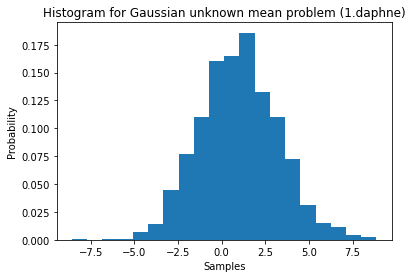

In [5]:
data = [x.item() for x in samples[0]]
plt.hist(data, density=True, bins=20)
plt.ylabel('Probability')
plt.xlabel('Samples')
plt.title('Histogram for Gaussian unknown mean problem (1.daphne)')
print("The mean (marginal expectation): {:.5f}".format(sum(data)/1000))

In [6]:
slope = [x.numpy()[0] for x in samples[1]]
bias = [x.numpy()[1] for x in samples[1]]

The mean (marginal expectation): -0.21468


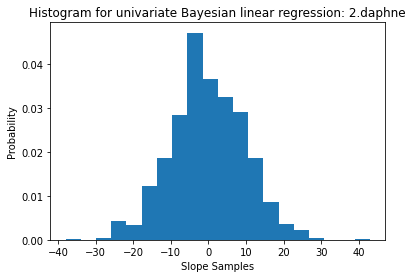

In [7]:
plt.hist(slope, density=True, bins=20)
plt.ylabel('Probability')
plt.xlabel('Slope Samples')
plt.title('Histogram for univariate Bayesian linear regression: 2.daphne')
print("The mean (marginal expectation): {:.5f}".format(sum(slope)/1000))

The mean (marginal expectation): 0.13627


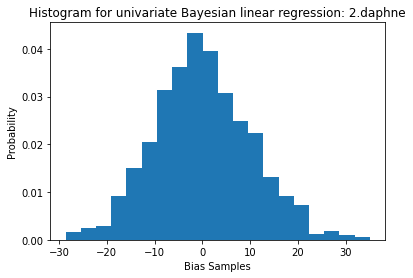

In [8]:
plt.hist(bias, density=True, bins=20)
plt.ylabel('Probability')
plt.xlabel('Bias Samples')
plt.title('Histogram for univariate Bayesian linear regression: 2.daphne')
print("The mean (marginal expectation): {:.5f}".format(sum(bias)/1000))

The mean (marginal expectation) per 'time-step': 
[1.059 1.448 1.448 1.469 1.509 1.474 1.493 1.488 1.504 1.467 1.489 1.477
 1.454 1.486 1.476 1.439 1.471]


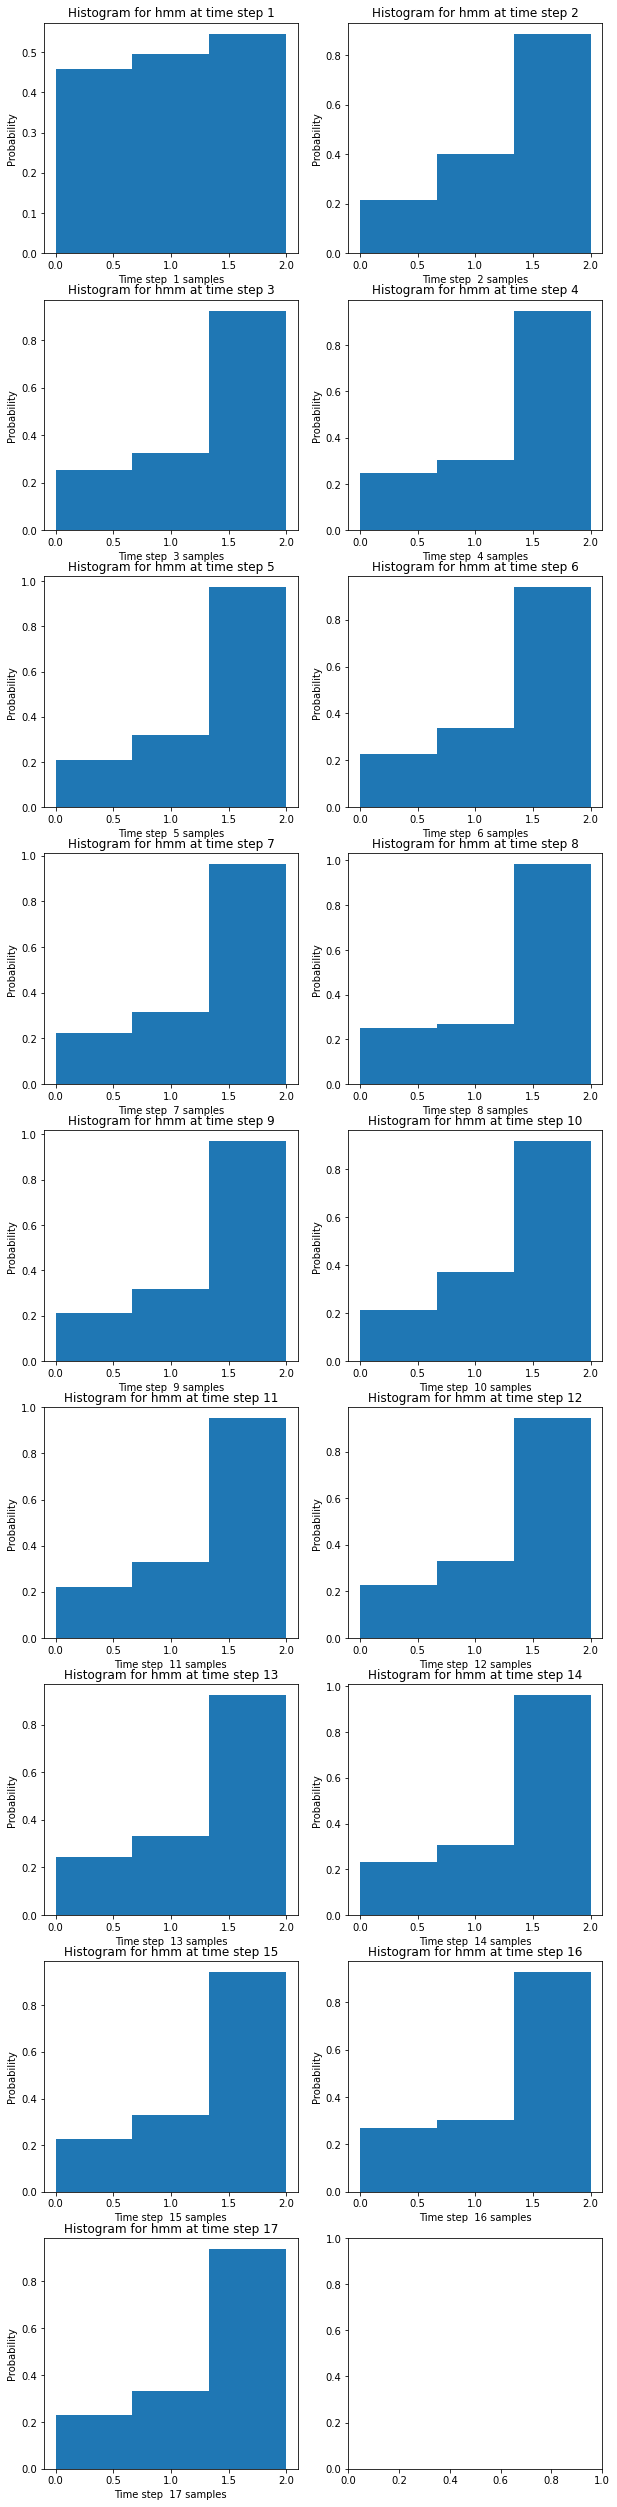

In [9]:
hmm = np.array([x.numpy() for x in samples[2]])
f, a = plt.subplots(9, 2, figsize=(10, 45))
a = a.ravel()
for i, ax in enumerate(a):
    if i == 17:
        break
    ax.hist(hmm[:, i], density=True, bins=3)
    ax.set_ylabel('Probability')
    ax.set_xlabel('Time step  {} samples'.format(i+1))
    ax.set_title('Histogram for hmm at time step {}'.format(i+1))

print("The mean (marginal expectation) per 'time-step': \n{}".format(np.mean(hmm, axis=0)))

In [10]:
full = np.array([x.numpy() for x in samples[3]])
W_0 = full[:, :, 0:1]
b_0 = full[:, :, 1:2]
W_1 = full[:, :, 2:12]
b_1 = full[:, :, 12:13]

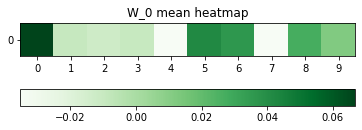

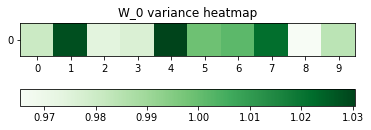

The mean (marginal expectation) for W_0: 
[[ 0.06680023]
 [-0.00961807]
 [-0.01285102]
 [-0.00981187]
 [-0.03515337]
 [ 0.04174173]
 [ 0.03624007]
 [-0.03486867]
 [ 0.02723   ]
 [ 0.01184643]]


In [11]:
W_0_mean = np.mean(W_0, axis=0)
W_0_std = np.std(W_0, axis=0)

mean = plt.imshow(W_0_mean.T, cmap='Greens')
plt.colorbar(mean, orientation="horizontal")
plt.title("W_0 mean heatmap")
plt.xticks(range(10))
plt.yticks(range(1))
plt.show()

std = plt.imshow(W_0_std.T, cmap='Greens')
plt.colorbar(std, orientation="horizontal")
plt.title("W_0 variance heatmap")
plt.xticks(range(10))
plt.yticks(range(1))
plt.show()

print("The mean (marginal expectation) for W_0: \n{}".format(np.mean(W_0, axis=0)))

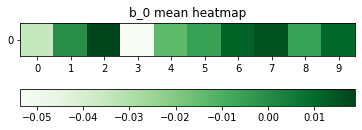

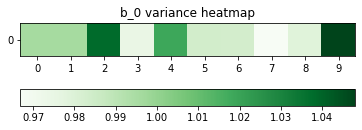

The mean (marginal expectation) for b_0: 
[[-0.03504807]
 [-0.00035397]
 [ 0.01883171]
 [-0.05355036]
 [-0.01351134]
 [-0.0055664 ]
 [ 0.0115547 ]
 [ 0.01550467]
 [-0.00625945]
 [ 0.01090641]]


In [12]:
b_0_mean = np.mean(b_0, axis=0)
b_0_std = np.std(b_0, axis=0)

mean = plt.imshow(b_0_mean.T, cmap='Greens')
plt.colorbar(mean, orientation="horizontal")
plt.title("b_0 mean heatmap")
plt.xticks(range(10))
plt.yticks(range(1))
plt.show()

std = plt.imshow(b_0_std.T, cmap='Greens')
plt.colorbar(std, orientation="horizontal")
plt.title("b_0 variance heatmap")
plt.xticks(range(10))
plt.yticks(range(1))
plt.show()

print("The mean (marginal expectation) for b_0: \n{}".format(np.mean(b_0, axis=0)))

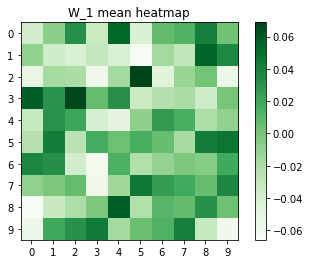

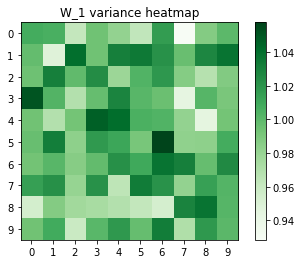

The mean (marginal expectation) for W_1: 
[[-3.83101739e-02 -9.06364527e-03 -5.06329723e-02  5.76284602e-02
  -3.20433527e-02 -2.46383529e-02  3.82047296e-02 -9.47851408e-03
  -6.57797083e-02 -5.57581224e-02]
 [-7.02425977e-03 -3.64055298e-02 -1.78790223e-02  3.06507908e-02
   3.11440285e-02  4.28478420e-02  3.34727429e-02 -2.58222315e-03
  -3.29759270e-02  1.91502683e-02]
 [ 3.21731940e-02 -4.27886061e-02 -2.02322751e-02  6.66641220e-02
   2.09033899e-02 -2.59929001e-02 -3.84046659e-02  6.63464796e-03
  -2.06449516e-02  3.18214856e-02]
 [-3.34250405e-02 -3.01748160e-02 -5.82740270e-02  6.30277256e-03
  -4.13000919e-02  1.69459544e-02 -6.13763407e-02 -5.83697334e-02
  -2.42833560e-03  4.38523255e-02]
 [ 5.38124405e-02 -4.26047780e-02 -1.69213563e-02  3.26603614e-02
  -4.99995872e-02  4.01768833e-03  1.47114089e-02 -1.51235182e-02
   5.74404523e-02 -1.74018424e-02]
 [-4.32846248e-02 -6.34177998e-02  6.87607303e-02 -3.45474780e-02
  -8.79876595e-03  1.60956383e-02 -2.19970252e-02  4.5180

In [13]:
W_1_mean = np.mean(W_1, axis=0)
W_1_std = np.std(W_1, axis=0)

mean = plt.imshow(W_1_mean.T, cmap='Greens')
plt.colorbar(mean, orientation="vertical")
plt.title("W_1 mean heatmap")
plt.xticks(range(10))
plt.yticks(range(10))
plt.show()

std = plt.imshow(W_1_std.T, cmap='Greens')
plt.colorbar(std, orientation="vertical")
plt.title("W_1 variance heatmap")
plt.xticks(range(10))
plt.yticks(range(10))
plt.show()

print("The mean (marginal expectation) for W_1: \n{}".format(np.mean(W_1, axis=0)))

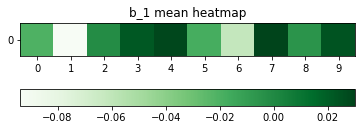

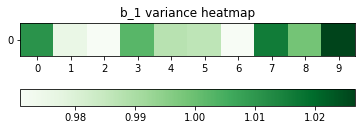

The mean (marginal expectation) for b_1: 
[[-0.02045907]
 [-0.09373967]
 [-0.00175478]
 [ 0.02222353]
 [ 0.02863886]
 [-0.01801291]
 [-0.06136297]
 [ 0.03016486]
 [-0.00555508]
 [ 0.02418666]]


In [14]:
b_1_mean = np.mean(b_1, axis=0)
b_1_std = np.std(b_1, axis=0)

mean = plt.imshow(b_1_mean.T, cmap='Greens')
plt.colorbar(mean, orientation="horizontal")
plt.title("b_1 mean heatmap")
plt.xticks(range(10))
plt.yticks(range(1))
plt.show()

std = plt.imshow(b_1_std.T, cmap='Greens')
plt.colorbar(std, orientation="horizontal")
plt.title("b_1 variance heatmap")
plt.xticks(range(10))
plt.yticks(range(1))
plt.show()

print("The mean (marginal expectation) for b_1: \n{}".format(np.mean(b_1, axis=0)))